In [3]:
# Import Library
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import tensorflow as tf


In [4]:
#defining training and testing path for vgg16
train_path = '/kaggle/input/intel-image-classification-vgg16/seg_train/seg_train'
valid_path = '/kaggle/input/intel-image-classification-vgg16/seg_test/seg_test'


In [5]:
# The number of classes of dataset
numberOfClass = len(glob(train_path + "/*"))
print("Number Of Class: ", numberOfClass)

Number Of Class:  6


In [6]:
#train_data is used for feature scaling and image augmentation (image augmentation is applied to avoid overfitting).
train_data = ImageDataGenerator(rescale = 1./255,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, validation_split=0.2)

#defining training set, here size of image is reduced to 150x150, batch of images is kept as 128 and class is defined as 'categorical'.
training_set = train_data.flow_from_directory(train_path, batch_size = 128, target_size = (150,150), class_mode = 'categorical', subset='training')
validation_set = train_data.flow_from_directory(train_path, batch_size = 128, target_size = (150,150), class_mode = 'categorical', subset='validation')

# Iterando sobre o conjunto de treinamento
for inputs, targets in training_set:
    print(inputs.shape)
    print(targets.shape)
    break 

for inputs, targets in validation_set:
    print(inputs.shape)
    print(targets.shape)
    break  


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
(128, 150, 150, 3)
(128, 6)
(128, 150, 150, 3)
(128, 6)


In [7]:
#applying same scale as training set, but only feature scaling is applied. image augmentation is avoided to prevent leakage of testing data.
test_data = ImageDataGenerator(rescale = 1./255)

#defining testing set
testing_set = test_data.flow_from_directory(valid_path, batch_size = 128, target_size = (150,150), class_mode = 'categorical')

# Iterando sobre o conjunto de teste
for inputs, targets in testing_set:
    print(inputs.shape)
    print(targets.shape)
    break

Found 3000 images belonging to 6 classes.
(128, 150, 150, 3)
(128, 6)


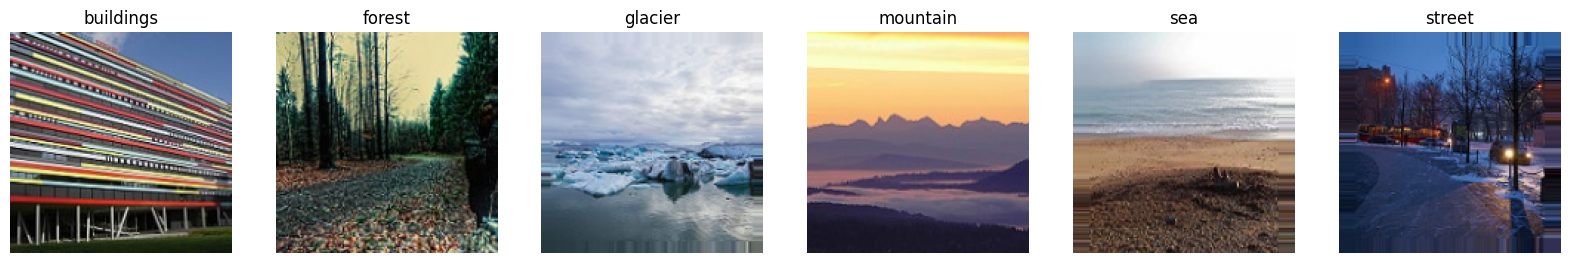

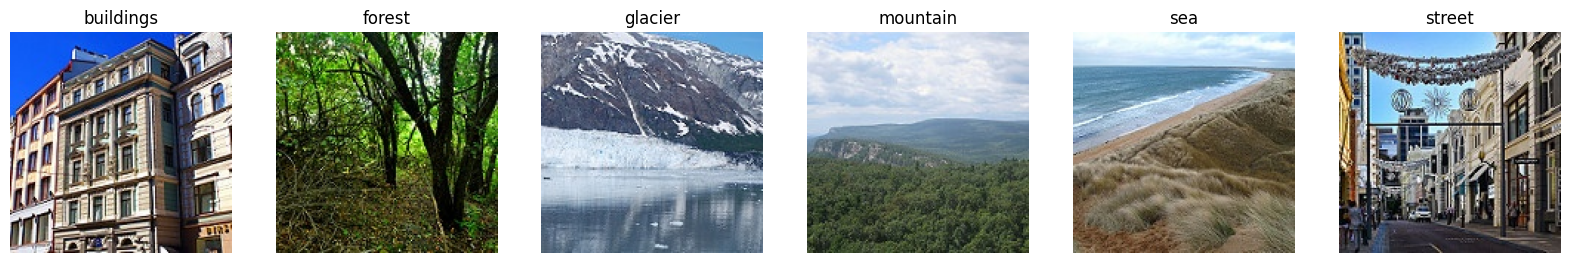

In [8]:
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

# Retrieve one batch of images from the training set
batch_images, batch_labels = next(training_set)

# Plot one image per class
for i in range(6):
    class_indices = np.where(batch_labels[:, i] == 1)[0]
    if len(class_indices) > 0:
        image_index = class_indices[0]
        axes[i].imshow(batch_images[image_index])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    else:
        axes[i].set_visible(False)
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))

# Retrieve one batch of images from the testing set
batch_images, batch_labels = next(testing_set)

# Plot one image per class
for i in range(6):
    class_indices = np.where(batch_labels[:, i] == 1)[0]
    if len(class_indices) > 0:
        image_index = class_indices[0]
        axes[i].imshow(batch_images[image_index])
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    else:
        axes[i].set_visible(False)
plt.show()

In [9]:
from keras.applications.vgg16 import VGG16

IMAGE_SIZE = [150,150]

#defining vgg16 model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='/kaggle/input/vgg16/tensorflow2/vgg16/1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False)

#we have to take pre trained weights, we don't want to train the weights again
for layer in vgg.layers:
    layer.trainable = False

#flattening the output of vgg16 for fully connected layer.
x = tf.keras.layers.Flatten()(vgg.output)

#adding output layer
#x = Dense(1000, activation='relu')(x) here pretrained model had 1000 neurons but we'll be replacing them by 6(no. of classes)
prediction = tf.keras.layers.Dense(numberOfClass, activation='softmax')(x)


In [10]:
#creating the model and getting the summary
model = tf.keras.models.Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        49,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,763,846 (56.32 MB)

 Trainable params: 49,158 (192.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
#compilithe model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
#fitting the model with 5 epochs#fitting the model with 5 epochs
history = model.fit(
    training_set,  # Dados de treinamento
    steps_per_epoch=training_set.samples // 128,  # Número de passos por época
    validation_data=validation_set,  # Dados de validação
    epochs=10,  # Número de épocas
    validation_steps=validation_set.samples // 128  # Número de passos de validação
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718186096.317578     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718186096.338841     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/87 ━━━━━━━━━━━━━━━━━━━━ 1:02:04 44s/step - accuracy: 0.2254 - loss: 1.9286

W0000 00:00:1718186140.215707     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6537 - loss: 0.9027

W0000 00:00:1718186240.986201     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.6550 - loss: 0.8995 - val_accuracy: 0.8322 - val_loss: 0.4618
Epoch 2/10
 1/87 ━━━━━━━━━━━━━━━━━━━━ 22s 257ms/step - accuracy: 0.7969 - loss: 0.4573

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
W0000 00:00:1718186318.693607     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 54s 621ms/step - accuracy: 0.7969 - loss: 0.4573 - val_accuracy: 0.8362 - val_loss: 0.4636
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8551 - loss: 0.4062 - val_accuracy: 0.8620 - val_loss: 0.3844
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8984 - loss: 0.3024 - val_accuracy: 0.8276 - val_loss: 0.5130
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8714 - loss: 0.3628 - val_accuracy: 0.8657 - val_loss: 0.3809
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8359 - loss: 0.4851 - val_accuracy: 0.8793 - val_loss: 0.2896
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8873 - loss: 0.3252 - val_accuracy: 0.8698 - val_loss: 0.3713
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8672 - loss: 0.4077 - val_accuracy: 0.9224 - val_loss: 0.2305
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8904 - loss: 0.3044 - val_accuracy: 0.8817 - val_loss: 0.3

In [13]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15, 10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], label = "Train Accuracy")
    plt.plot(history.history['val_accuracy'], label = "Validation Accuracy")
    plt.title("Train Accuracy vs Validation Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'], label = "Train Loss")
    plt.plot(history.history['val_loss'], label = "Validation Loss")
    plt.title("Train Loss vs Validation Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

    plt.legend()
    plt.show()

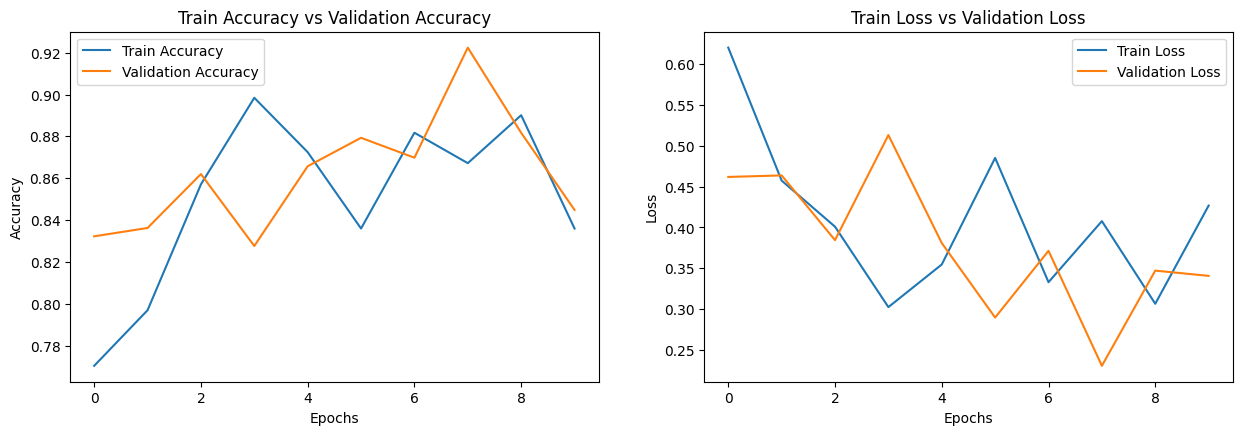

In [14]:
plot_accuracy_loss(history)